# Saffman, M., et al. "Symmetric Rydberg controlled-Z gates with adiabatic pulses." Physical Review A 101.6 (2020): 062309.

In this simulation, we shape $\Omega1$ and let $\Omega2$, $\Delta1$ and $\Delta2$ be constants.

In [1]:
%cd /home/thc/Ubuntu_data/run_Saffman_shape-o1tgate_fixo2d1d2

/home/thc/Ubuntu_data/run_Saffman_shape-o1tgate_fixo2d1d2


In [2]:
from IPython.display import clear_output

from qutip import *
import math

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from rdquantum.pulse_shape import Saffman_shape
from rdquantum.fidelity import fidelity
from rdquantum.optimizer.de import de

# Physical system

In [3]:
### Hamiltonian ###
def Hamiltonian(shape_omega1, value_omega2, value_delta1, value_delta2):
    rho = []    # 0, 1, p, r, d
    for i in range(5):
        rho.append(ket2dm(basis(5,i)))

    I = qeye(5)

    H_omega1 = np.zeros((5,5))
    H_omega1[2][1] = 2*np.pi / 2
    H_omega1[1][2] = 2*np.pi / 2
    H_omega1 = Qobj(H_omega1)

    # Let Omega2, Delta1 and Delta2 be constants.
    H_omega2 = np.zeros((5,5))
    H_omega2[3][2] = 2*np.pi / 2 * value_omega2[0]
    H_omega2[2][3] = 2*np.pi / 2 * value_omega2[0]
    H_omega2 = Qobj(H_omega2)

    H_delta1 = np.zeros((5,5))
    H_delta1[2][2] = 2*np.pi * value_delta1[0]
    H_delta1 = Qobj(H_delta1)
    
    value_delta = value_delta1[0] + value_delta2[0]
    H_delta = np.zeros((5,5))
    H_delta[3][3] = 2*np.pi * value_delta
    H_delta = Qobj(H_delta)

    B = 2*np.pi * 500           # (MHz) Strength of Rydberg states interaction
    Brr = np.zeros((5,5))
    Brr[3][3] = np.sqrt(B)
    Brr = tensor(Qobj(Brr), Qobj(Brr))

    H = [[tensor(H_omega1, I) + tensor(I, H_omega1), shape_omega1], 
         [tensor(H_omega2, I) + tensor(I, H_omega2), '1'], 
         [tensor(H_delta1, I) + tensor(I, H_delta1), '1'], 
         [tensor(H_delta, I) + tensor(I, H_delta), '1'],
         [Brr, '1']]

    return H


### Pulse shape omega1(t), omega2(t) and delta1(t) ###
def PulseShape(times, T_gate, n_seg, Pulses):

    def shape_omega1(t, arg):
        return Saffman_shape(t,T_gate, n_seg, Pulses['Omega1'], conjugate=False)
    
    def shape_omega1_star(t, arg):
        return Saffman_shape(t,T_gate, n_seg, Pulses['Omega1'], conjugate=True)

    value_omega2 = Pulses['Omega2']

    value_delta1 = Pulses['Delta1']
    
    value_delta2 = Pulses['Delta2']
    
    return shape_omega1, shape_omega1_star, value_omega2, value_delta1, value_delta2


### Decay term, c_ops ###
def Decay(gammap=1/0.155, gammar=1/540):
    # gammap: (1/mu s) population decay rate of the Rydberg state
    # gammar: (1/mu s) population decay rate of the P state
    c_ops = []
    I = qeye(5)

    L0p = np.zeros((5,5))
    L0p[0][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L0p), I))
    c_ops.append(tensor(I, Qobj(L0p)))

    L0r = np.zeros((5,5))
    L0r[0][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L0r), I))
    c_ops.append(tensor(I, Qobj(L0r)))

    L1p = np.zeros((5,5))
    L1p[1][2] = np.sqrt(1/16 * gammap)
    c_ops.append(tensor(Qobj(L1p), I))
    c_ops.append(tensor(I, Qobj(L1p)))

    L1r = np.zeros((5,5))
    L1r[1][3] = np.sqrt(1/32 * gammar)
    c_ops.append(tensor(Qobj(L1r), I))
    c_ops.append(tensor(I, Qobj(L1r)))

    Ldp = np.zeros((5,5))
    Ldp[4][2] = np.sqrt(7/8 * gammap)
    c_ops.append(tensor(Qobj(Ldp), I))
    c_ops.append(tensor(I, Qobj(Ldp)))

    Ldr = np.zeros((5,5))
    Ldr[4][3] = np.sqrt(7/16 * gammar)
    c_ops.append(tensor(Qobj(Ldr), I))
    c_ops.append(tensor(I, Qobj(Ldr)))

    Lpr = np.zeros((5,5))
    Lpr[2][3] = np.sqrt(1/2 * gammar)
    c_ops.append(tensor(Qobj(Lpr), I))
    c_ops.append(tensor(I, Qobj(Lpr)))

    return c_ops


### Create two qubits state as density matrix, dm(control_qubit, target_qubit) ###
# def dm(control_qubit, target_qubit):
#     return ket2dm( tensor(basis(5, control_qubit), basis(5, target_qubit)) )

# Gate Operation

In [4]:
# Gate operation
def GateOp(Pulses, rho_init, targets):
    T_gate = Pulses['T_gate'][0]              # (mu s) Total gate time
    times = np.linspace(0.0, T_gate, 100)
    n_seg = 2*len(Omega1)   # Number of segments

    shape_omega1, shape_omega1_star, value_omega2, value_delta1, value_delta2 = PulseShape(times, T_gate, n_seg, Pulses)
    H = Hamiltonian(shape_omega1, value_omega2, value_delta1, value_delta2)
    c_ops = Decay(1/0.155, 1/540)
    
    results = mesolve(H, rho_init, times, c_ops, targets, options=Options(nsteps=10000))
    return results

# Outpout

In [5]:
Omega1 = [1.38, 10.30, 25.54, 42.85, 82.50, 93.35]
# Omega1_Phase = [0, 0, 0, 0, 0, 0]
# Omega1_Phase = None
Omega2 = [175]
Delta1 = [300]
Delta2 = [300]
T_gate = [1]
Pulses = {'Omega1': Omega1, 'Omega2': Omega2, 
          'Delta1': Delta1, 'Delta2': Delta2, 
          'T_gate': T_gate}
PulsesRange = {'Omega1': [0, 100], 'Omega2': [0, 200], 
               'Delta1': [300, 450], 'Delta2': [-450, -300],
               'T_gate': [0.5, 2.5]}

Had = np.zeros((5,5))
Had[0][0] = 1
Had[0][1] = 1
Had[1][0] = 1
Had[1][1] = -1

I = qeye(5)
Had = Qobj(Had/np.sqrt(2))

ket00 = tensor(basis(5,0), basis(5,0))
ket01 = tensor(basis(5,0), basis(5,1))
ket10 = tensor(basis(5,1), basis(5,0))
ket11 = tensor(basis(5,1), basis(5,1))

# Target Bell state, rho_bell = 1/sqrt(2) * (|01> + |10>)
rho0101 = tensor(I, Had) * ket2dm(ket01) * tensor(I, Had)
rho1010 = tensor(I, Had) * ket2dm(ket10) * tensor(I, Had)
rho0110 = tensor(I, Had) * (ket10 * ket01.dag()) * tensor(I, Had)
rho_bell = [rho0101, rho1010, rho0110]

# Initial state, rhoi = |01><01|
rhoi = tensor(Had, Had) * ket2dm(ket01) * tensor(Had, Had)

bell_fidelity = fidelity(GateOp)
print(bell_fidelity.get_fidelity(Pulses, rhoi, rho_bell))

0.30408851404957277


# Differentail Evolution

In [6]:
K = len(Pulses)
# diffevo = de(bell_fidelity, K, 0, 500)
diffevo = de(bell_fidelity, rhoi, rho_bell)
diffevo.createPopulations(Pulses, PulsesRange)

In [18]:
diffevo.start(itr=10000, batch=10)

Number of control parameters: 10
Populations size: 150
Start differential evolution...
Iterations: 10000
Optimized fidelity: 0.9978173534719046
# 10000 batch iteration.

Fidelity (Ci, Di) = 0.9978154674079007 0.9978160996124394, population 11 unchanged
Fidelity (Ci, Di) = 0.9978159356062268 0.9978160101969524, population 139 unchanged
Fidelity (Ci, Di) = 0.9977326699278304 0.9978159703417219, population 40 unchanged
Fidelity (Ci, Di) = 0.9977610877883413 0.9978159480027851, population 46 unchanged
Fidelity (Ci, Di) = 0.9976396568118956 0.9978158818934264, population 79 unchanged
Fidelity (Ci, Di) = 0.9978155801700542 0.9978163404962916, population 52 unchanged
Fidelity (Ci, Di) = 0.9963575978383027 0.9978167684612209, population 49 unchanged
Fidelity (Ci, Di) = 0.9977525356295703 0.997817057109274, population 135 unchanged
Fidelity (Ci, Di) = 0.9978160139428797 0.997816283611167, population 115 unchanged
Optimized Fidelity: 0.9978173534719046 0.9978163987292272, population 132 unchange

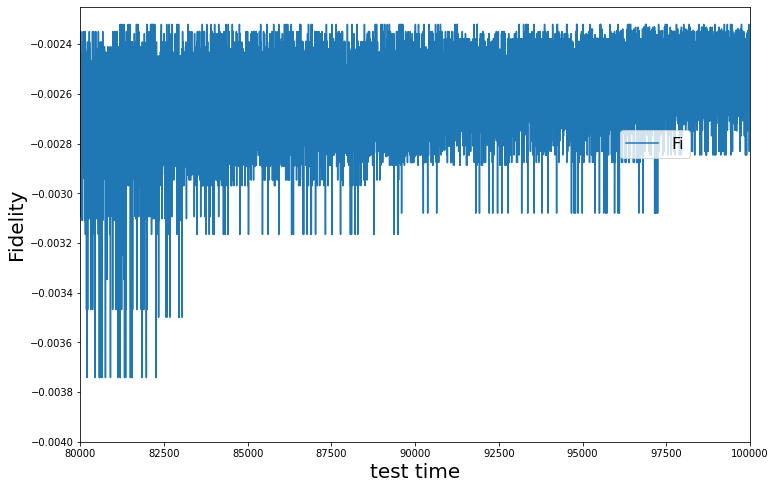

In [15]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(np.log(diffevo.data_fidelity), label="Fi")

ax1.set_xlabel("test time", fontsize=20) 
ax1.set_ylabel("Fidelity", fontsize=20)

plt.xlim([80000, 100000])
plt.ylim([-0.004, -0.00225])

fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [ ]:
testnpy = np.load("out.npz")

In [ ]:
print(diffevo.op_pulse)

In [16]:
# Pulse shape
T_gate = diffevo.op_pulse['T_gate'][0]    # (mu s) Total gate time
n = 12   # Number of segments
dt = T_gate/n       # (mu s) Duration of each segment
def Pshape(t, pulse_coe):
        ith = int( (t - dt/2) // dt )
        ti = dt/2 + dt*ith
        ti1 = ti + dt
        
        if t < dt/2 or t > (T_gate - dt/2):
            fi = pulse_coe[0]
            fi1 = pulse_coe[0]
            ft = (fi + fi1)/2 

        else:
            if ith < 5:
                ith1 = ith + 1
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith == 5:
                ith1 = ith
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith > 5:
                ith1 = ith + 1
                fi = pulse_coe[n-ith-1]
                fi1 = pulse_coe[n-ith1-1]
                ft  = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

        return ft

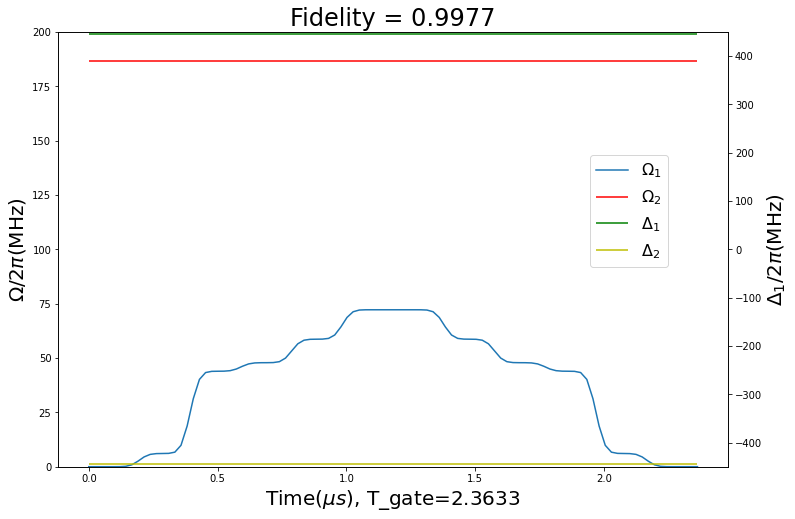

In [17]:
Omega1 = diffevo.op_pulse['Omega1']
Omega2 = diffevo.op_pulse['Omega2'][0]
Delta1 = diffevo.op_pulse['Delta1'][0]
Delta2 = diffevo.op_pulse['Delta2'][0]

times = np.linspace(0.0, T_gate, 100)

pulse_Omega1 = []

for t in times:
    pulse_Omega1.append( Pshape(t, Omega1))
    # pulse_Omega2.append( Pshape(t, Omega2))
    # delta1.append( Pshape(t, Delta1))

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(times, pulse_Omega1, label=r'$\Omega_1$')
ax1.hlines(y=Omega2, xmin=0, xmax=T_gate, label=r'$\Omega_2$', color='r')
ax1.set_ylim(0, 200)

ax2 = ax1.twinx()
ax2.hlines(y=Delta1, xmin=0, xmax=T_gate, label=r'$\Delta_1$', color='g')
ax2.hlines(y=Delta2, xmin=0, xmax=T_gate, label=r'$\Delta_2$', color='y')
ax2.set_ylim(-450, 450)

ax1.set_xlabel('Time' r'$(\mu s)$, T_gate=%.4f' %T_gate, fontsize=20) 
ax1.set_ylabel(r'$\Omega / 2 \pi$' '(MHz)', fontsize=20)
ax2.set_ylabel(r'$\Delta_1 / 2 \pi$' '(MHz)', fontsize=20)

plt.title("Fidelity = %.4f" %diffevo.op_fidelity, fontsize=24)
fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [22]:
# Pulse shape
T_gate = diffevo.op_pulse['T_gate'][0]    # (mu s) Total gate time
n = 12   # Number of segments
dt = T_gate/n       # (mu s) Duration of each segment
def Pshape(t, pulse_coe):
        ith = int( (t - dt/2) // dt )
        ti = dt/2 + dt*ith
        ti1 = ti + dt
        
        if t < dt/2 or t > (T_gate - dt/2):
            fi = pulse_coe[0]
            fi1 = pulse_coe[0]
            ft = (fi + fi1)/2 

        else:
            if ith < 5:
                ith1 = ith + 1
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith == 5:
                ith1 = ith
                fi = pulse_coe[ith]
                fi1 = pulse_coe[ith1]
                ft = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

            elif ith > 5:
                ith1 = ith + 1
                fi = pulse_coe[n-ith-1]
                fi1 = pulse_coe[n-ith1-1]
                ft  = ( (fi + fi1)/2 + ( (fi1-fi)/2 ) * math.erf( (5/dt) * ( t - (ti + ti1)/2 ) ) )

        return ft

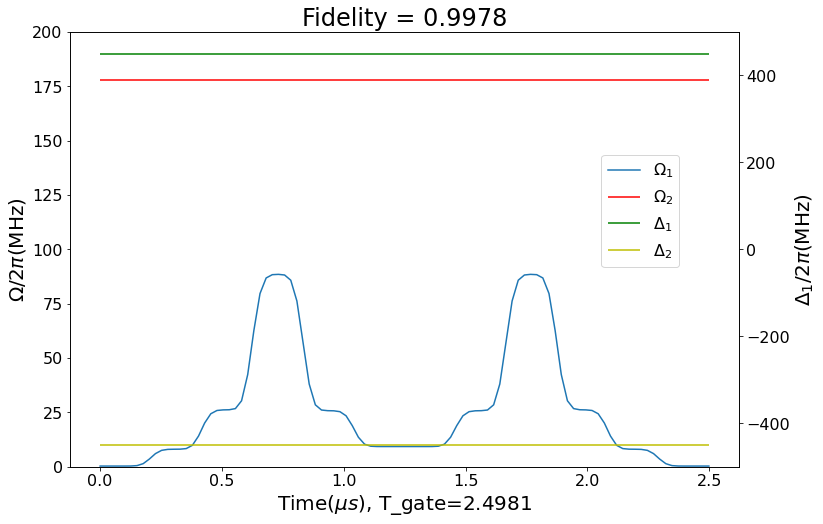

In [33]:
Omega1 = diffevo.op_pulse['Omega1']
Omega2 = diffevo.op_pulse['Omega2'][0]
Delta1 = diffevo.op_pulse['Delta1'][0]
Delta2 = diffevo.op_pulse['Delta2'][0]

times = np.linspace(0.0, T_gate, 100)

pulse_Omega1 = []

for t in times:
    pulse_Omega1.append( Pshape(t, Omega1))
    # pulse_Omega2.append( Pshape(t, Omega2))
    # delta1.append( Pshape(t, Delta1))

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(times, pulse_Omega1, label=r'$\Omega_1$')
ax1.hlines(y=Omega2, xmin=0, xmax=T_gate, label=r'$\Omega_2$', color='r')
ax1.set_ylim(0, 200)
ax1.xaxis.set_tick_params(labelsize=16)
ax1.yaxis.set_tick_params(labelsize=16)

ax2 = ax1.twinx()
ax2.hlines(y=Delta1, xmin=0, xmax=T_gate, label=r'$\Delta_1$', color='g')
ax2.hlines(y=Delta2, xmin=0, xmax=T_gate, label=r'$\Delta_2$', color='y')
ax2.set_ylim(-500, 500)
ax2.yaxis.set_tick_params(labelsize=16)

ax1.set_xlabel('Time' r'$(\mu s)$, T_gate=%.4f' %T_gate, fontsize=20) 
ax1.set_ylabel(r'$\Omega / 2 \pi$' '(MHz)', fontsize=20)
ax2.set_ylabel(r'$\Delta_1 / 2 \pi$' '(MHz)', fontsize=20)

plt.title("Fidelity = %.4f" %diffevo.op_fidelity, fontsize=24)
fig.legend(bbox_to_anchor=(.84, .68), fontsize=16)

In [21]:
print(diffevo.op_pulse)xticks

{'Omega1': [0.339934933508385, 8.08528419522752, 26.195545239539186, 88.5250158313734, 25.79391709975359, 9.316862564073897], 'Omega2': [177.76042915314986], 'Delta1': [449.92004970439916], 'Delta2': [-449.98278212374976], 'T_gate': [2.498125850577228]}
